<a href="https://colab.research.google.com/github/MaJu502/proyectoDL/blob/main/ProyectoDL2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python

In [ ]:
!pip install mtcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 29.5 MB/s eta 0:00:00


In [1]:
import os
import cv2
import torch
import numpy as np
from PIL import Image
from mtcnn import MTCNN
from torchvision.transforms import functional as F

In [ ]:
# Carpeta que contiene los videos
video_folder = 'videos/'

# Carpeta de salida para guardar los frames
output_folder = 'frames/'

# Crea la carpeta de salida si no existe
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Lista de archivos en la carpeta de videos
video_files = os.listdir(video_folder)

for video_file in video_files:
    if video_file.endswith('.mp4') or video_file.endswith('.avi'):
        video_path = os.path.join(video_folder, video_file)

        # Abre el video
        cap = cv2.VideoCapture(video_path)

        # Verifica si el video se abrió correctamente
        if not cap.isOpened():
            print(f"No se pudo abrir el video: {video_path}")
            continue

        frame_count = 0

        # Lee y guarda los frames como imágenes
        while True:
            ret, frame = cap.read()

            if not ret:
                break

            # Guarda el frame como una imagen
            frame_filename = os.path.join(output_folder, f'{os.path.splitext(video_file)[0]}_frame_{frame_count:04d}.png')
            cv2.imwrite(frame_filename, frame)

            frame_count += 1

        # Cierra el video
        cap.release()

        print(f'Se han guardado {frame_count} frames del video {video_file} como imágenes.')

print('Proceso completo.')

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-11-7 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


1/1 [==============================] - 0s 33ms/step


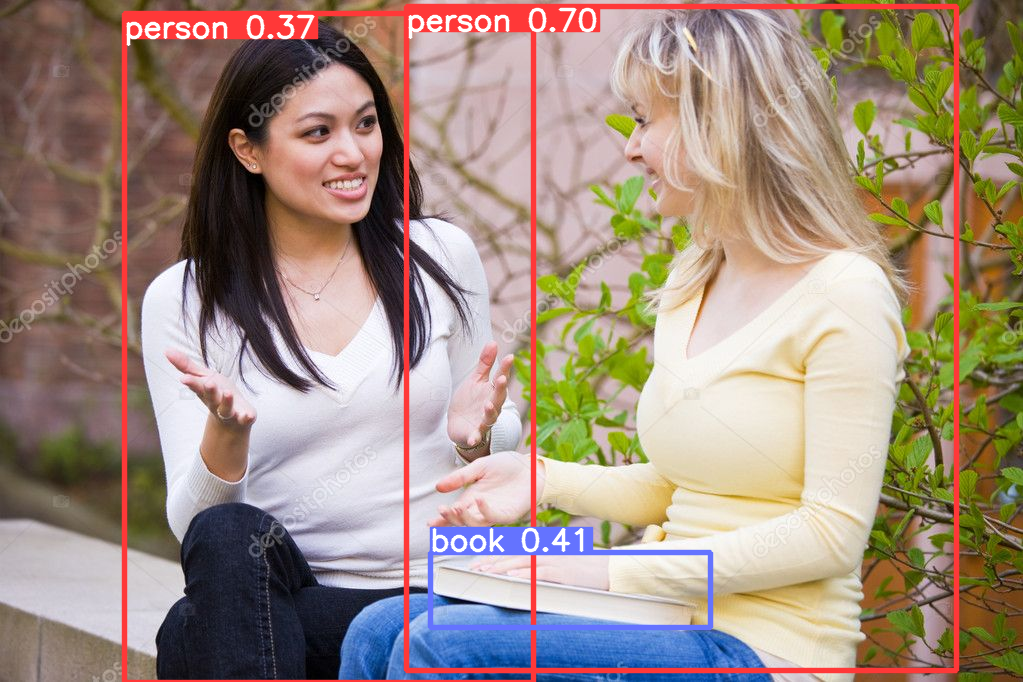

1/1 [==============================] - 0s 42ms/step


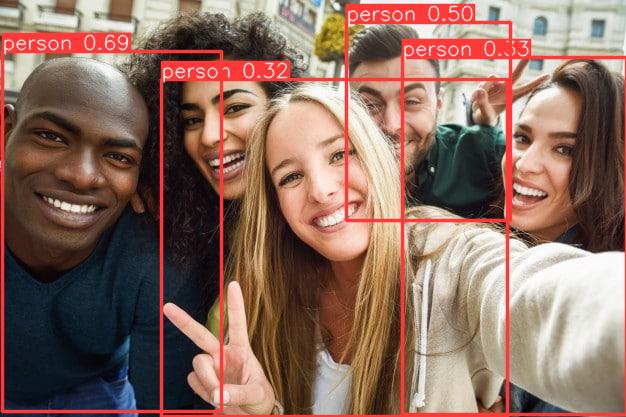

In [4]:
# Model YOLO
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
# Model MTCNN
face_detector = MTCNN()

# Carpeta de salida para guardar resultados
output_folder = 'persons/'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Carpeta que contiene los frames del video
folder = 'frames/'
files = os.listdir(folder)

# Obtener  lista de los archivos en el directorio
files = os.listdir(folder)

# Evaluar cada elemento dentro de frames
for img_name in files:
    img_path = os.path.join("frames", img_name)
    img = Image.open(img_path)
    results = model(img)

    # Obtener resultados de bounding boxes
    bboxes = results.pred[0]

    for i, bbox in enumerate(bboxes):
        # Ver si la clase es de tipo person
        if bbox[-1] == 0:
            x1, y1, x2, y2 = bbox[0:4].int().tolist()

            # Recortar imagen para obtener unicamente la caja
            cropped_img = img.crop((x1, y1, x2, y2))

            # Recortar caja para obtener unicamente las caras
            image_np = np.array(cropped_img)
            face_results = face_detector.detect_faces(image_np)

            if len(face_results) > 0:
               face_bbox = face_results[0]['box']
               x, y, w, h = face_bbox
               face_image = cropped_img.crop((x, y, x + w, y + h))

               # Guardar imagen en carpeta persona
               output_path = os.path.join(output_folder, f"person_{os.path.splitext(img_name)[0]}_{i}.jpg")
               face_image.save(output_path)

    results.show()
